Imports necessary for this notebook

In [1]:
import numpy as np
import pandas as pd
from scipy import stats, signal
import matplotlib.pyplot as plt
import seaborn as sns

Let's read the data and take a look

In [2]:
dataset_path = '../data/dataset_20221127.csv'
df = pd.read_csv(dataset_path)
df

,state,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,...,t_990,t_991,t_992,t_993,t_994,t_995,t_996,t_997,t_998,t_999
0,0,0.717573,0.714725,0.704585,0.694305,0.687011,0.683188,0.682031,0.682287,0.682855,...,22.574360,22.291788,22.200832,22.117663,21.933806,21.704434,21.518837,21.423986,21.415594,21.471398
1,0,0.719402,0.717330,0.708022,0.698305,0.691041,0.686480,0.683860,0.682345,0.681356,...,21.606304,21.749150,21.913914,22.131298,22.423522,22.622597,22.538945,22.260577,21.968238,21.749753
2,0,0.723090,0.721113,0.711632,0.701274,0.692945,0.687295,0.683872,0.682021,4.548630,...,21.920634,22.191567,22.503530,22.636686,22.477095,22.179683,21.903873,21.712412,21.651748,21.751566
3,0,0.729627,0.726485,0.715613,0.704214,0.695404,0.689836,0.686908,0.685656,0.685570,...,21.762202,21.882131,21.835883,21.622620,21.348106,21.087030,20.890951,20.803209,20.818334,20.924658
4,0,0.714636,0.714388,0.706626,0.698127,0.691818,0.688184,0.686566,0.686016,0.685919,...,22.371510,22.625730,22.591585,22.306095,21.983154,21.734184,21.610245,21.653387,21.830623,21.990501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2,0.722422,0.720920,0.712699,0.704530,0.699261,0.697420,0.698031,0.699691,0.701472,...,21.894379,21.584036,21.304952,21.153940,21.151720,21.236818,21.327983,21.391321,21.457854,21.514769
496,2,0.726260,0.726227,0.725950,0.725444,0.724643,0.723600,0.722467,0.721402,0.720516,...,21.156471,21.265720,21.441487,21.636681,21.779605,21.748118,21.535488,21.231456,20.924576,20.711599
497,2,0.726733,0.724837,0.715531,0.705948,0.699105,0.695240,0.693513,0.692998,0.692989,...,20.651314,20.724568,20.833982,21.013726,21.390266,22.054985,22.953415,23.751640,24.014938,23.732403
498,2,0.747386,0.745534,0.735654,0.724924,0.716467,0.710962,0.708025,0.706941,0.706846,...,23.195035,22.725279,22.423966,22.218512,21.978482,21.673394,21.376617,21.186890,21.152177,21.217464


#### How many rows do we have for each state?

In [3]:
df.groupby(['state']).size()

state
0    300
1    100
2    100
dtype: int64

three times more working engines
and an equal number of each type of broken engines

#### Are there missing or NAN values?

In [4]:
nan_count = df.isna().sum().sum()
print(nan_count, "nan values found!")

23 nan values found!


how many NANs per label?

In [5]:
na_df = df.isna()
na_df['state'] = df['state']
na_df.groupby('state').sum().sum(axis=1)

state
0    13
1     3
2     7
dtype: int64

removing NAN values will get us an uneven quantity of the two type of broken engines

but for now let just remove this values

In [6]:
not_na_df = df.dropna()
print(not_na_df.isna().sum().sum(), "nan values found!")

0 nan values found!


#### Some statistical information about the features

firstly, the label

In [7]:
df['state'] = df['state'].astype('category')
df['state'].describe()

count     500
unique      3
top         0
freq      300
Name: state, dtype: int64

now for current and tension

In [8]:
labels = [0, 1, 2]
features = ['current', 'voltage']
label_split = []
for label in labels:
    feat_df_3d = not_na_df[not_na_df['state'] == label].drop(columns=['state'])
    feat_df_3d.columns = pd.MultiIndex.from_tuples([(features[c[0] == 't'], c) for c in feat_df_3d.columns])
    feat_df = pd.concat([feat_df_3d[c].unstack().reset_index()[0] for c in feat_df_3d.columns.levels[0]], axis=1)
    feat_df.columns = features
    feat_df['state'] = label
    feat_df['state'] = feat_df['state'].astype('category')
    label_split.append(feat_df)
label_mult_index_df = pd.concat(label_split, axis=1, keys=labels)
label_mult_index_df.describe()

0                            1                           2  \
             current        voltage       current       voltage       current   
count  288000.000000  288000.000000  97000.000000  97000.000000  94000.000000   
mean        0.689264      22.044635      0.890812     21.665591      0.702334   
std         0.032326       1.025083      0.100502      2.721973      0.041531   
min         0.622967       0.234658      0.710802      2.365598      0.595338   
25%         0.676121      21.379161      0.802473     19.589508      0.678091   
50%         0.688727      21.863059      0.871379     20.672930      0.708244   
75%         0.705339      22.533723      0.972040     23.531722      0.730281   
max        11.554880     111.454900      3.658796     35.565650      7.564789   

                     
            voltage  
count  94000.000000  
mean      22.035493  
std        2.101310  
min        1.239898  
25%       21.122470  
50%       21.685749  
75%       22.423101  
max       42.831231

here we can see current and voltage details for each label

some data seems off, on label 1 the current has a max value of 1214, it is probably an outlier

on label 0, data seems to be more packed than on the other features

lets do some plotting to better analyze this hypothesis

In [9]:
label_df = pd.concat(label_split, ignore_index=True)
label_df['state'] = label_df['state'].astype('category')
label_df

,current,voltage,state
0,0.717573,24.521245,0
1,0.719402,24.476110,0
2,0.729627,24.547889,0
3,0.714636,24.573959,0
4,0.709658,24.551453,0
...,...,...,...
478995,0.653173,21.514769,2
478996,0.692476,20.711599,2
478997,0.711744,23.732403,2
478998,0.669758,21.217464,2


In [10]:
label_df_melted = label_df.melt(id_vars='state', value_vars=features, var_name='feature')
label_df_melted

,state,feature,value
0,0,current,0.717573
1,0,current,0.719402
2,0,current,0.729627
3,0,current,0.714636
4,0,current,0.709658
...,...,...,...
957995,2,voltage,21.514769
957996,2,voltage,20.711599
957997,2,voltage,23.732403
957998,2,voltage,21.217464


<AxesSubplot: xlabel='state', ylabel='value'>

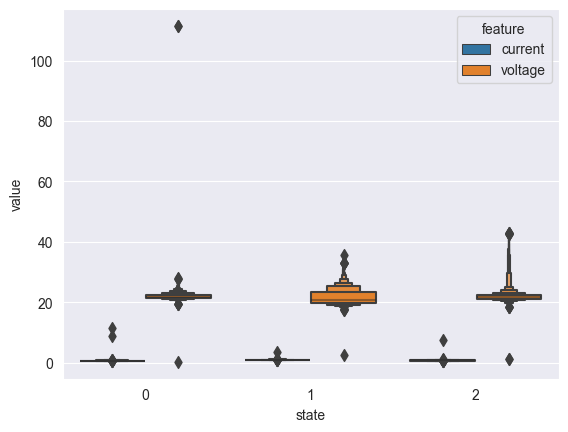

In [11]:
sns.boxenplot(data=label_df_melted, x='state', y='value', hue='feature')

we can clearly see some outliers

lets remake this plot removing data too far from the standard deviation

In [12]:
label_df_melted_clean = label_df_melted[(np.abs(stats.zscore(label_df_melted['value'])) < 5)]
label_df_melted_clean

,state,feature,value
0,0,current,0.717573
1,0,current,0.719402
2,0,current,0.729627
3,0,current,0.714636
4,0,current,0.709658
...,...,...,...
957995,2,voltage,21.514769
957996,2,voltage,20.711599
957997,2,voltage,23.732403
957998,2,voltage,21.217464


<AxesSubplot: xlabel='state', ylabel='value'>

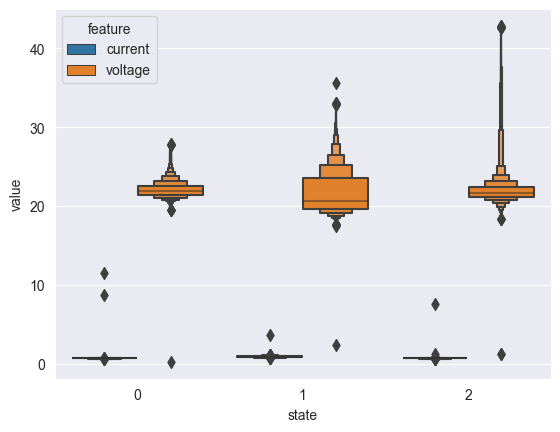

In [13]:
sns.boxenplot(data=label_df_melted_clean, x='state', y='value', hue='feature')

let's check the features separately

In [14]:
label_df_clean = label_df[(np.abs(stats.zscore(label_df[features])) < 5).all(axis=1)]
label_df_clean

,current,voltage,state
0,0.717573,24.521245,0
1,0.719402,24.476110,0
2,0.729627,24.547889,0
3,0.714636,24.573959,0
4,0.709658,24.551453,0
...,...,...,...
478995,0.653173,21.514769,2
478996,0.692476,20.711599,2
478997,0.711744,23.732403,2
478998,0.669758,21.217464,2


<AxesSubplot: xlabel='state', ylabel='current'>

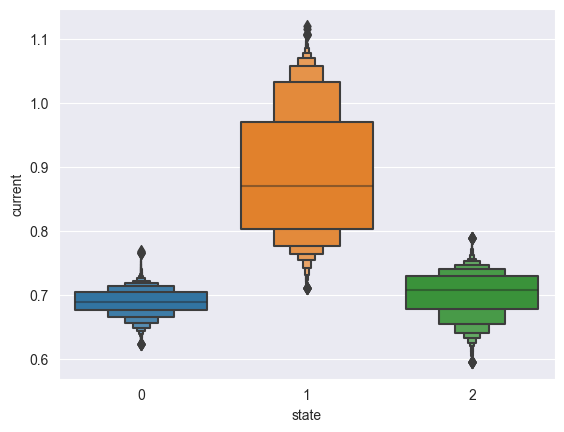

In [15]:
sns.boxenplot(data=label_df_clean, x='state', y='current')

<AxesSubplot: xlabel='state', ylabel='voltage'>

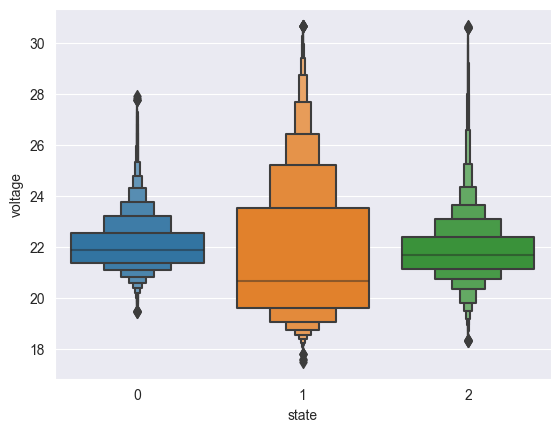

In [16]:
sns.boxenplot(data=label_df_clean, x='state', y='voltage')

we can make several observations based on the above plots

label 0 is the most grouped data

label 2 has similar mean to label 0

label 1 has the greatest std

##### relation between mean current and mean voltage per line

In [17]:
mean_feat_df = df.drop(columns=['state'])
mean_feat_df.columns = pd.MultiIndex.from_tuples([(features[c[0] == 't'], c) for c in mean_feat_df.columns])
mean_feat_df = mean_feat_df.groupby(level=0, axis=1).mean()
mean_feat_df.columns = [f"mean_{c}" for c in mean_feat_df.columns]
mean_feat_df['state'] = df['state']
mean_feat_df

,mean_current,mean_voltage,state
0,0.683705,22.151397,0
1,0.679833,22.066898,0
2,0.690525,22.070464,0
3,0.692794,22.012264,0
4,0.680013,22.076911,0
...,...,...,...
495,0.685177,22.086528,2
496,0.692129,22.053290,2
497,0.690922,22.061742,2
498,0.686268,22.079134,2


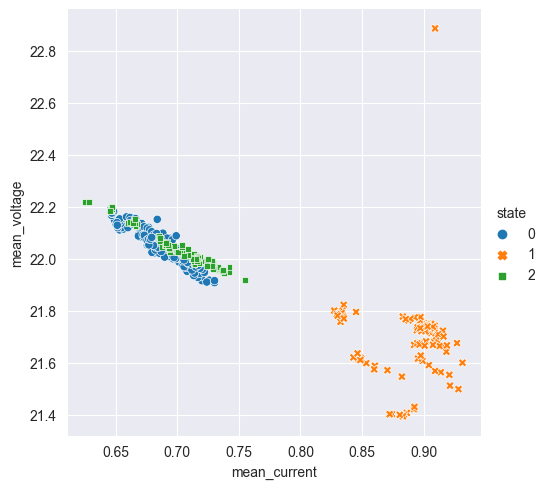

In [18]:
sns.relplot(data=mean_feat_df, x='mean_current', y='mean_voltage', hue='state', style='state')

we can easily see there is a clear distinction on defect type 1

both mean_voltage and mean_average are way off the normal

however there is no clear distinction from defect type 2 and normal

#### Random sample of each feature

In [19]:
labels

[0, 1, 2]

In [20]:
label_samples = []
for label in labels:
    label_sample_df = df[df['state'] == label].drop(columns=['state']).sample(n=10, random_state=0)
    label_sample_df.columns = pd.MultiIndex.from_tuples([(features[c[0] == 't'], c.split('_')[1]) for c in label_sample_df.columns])
    label_sample_df = label_sample_df.transpose()
    label_sample_df = label_sample_df.melt(ignore_index=False, var_name='ori_line')
    label_sample_df = label_sample_df.reset_index(names=['feature', 'ori_column'])
    label_samples.append(label_sample_df)
label_samples[0]

,feature,ori_column,ori_line,value
0,current,0,208,0.744507
1,current,1,208,0.741720
2,current,2,208,0.731674
3,current,3,208,0.721409
4,current,4,208,0.713688
...,...,...,...,...
19995,voltage,995,108,21.750851
19996,voltage,996,108,21.798354
19997,voltage,997,108,21.935375
19998,voltage,998,108,22.162565


In [21]:
current_samples = [df[df['feature'] == 'current'] for df in label_samples]
voltage_samples = [df[df['feature'] == 'voltage'] for df in label_samples]

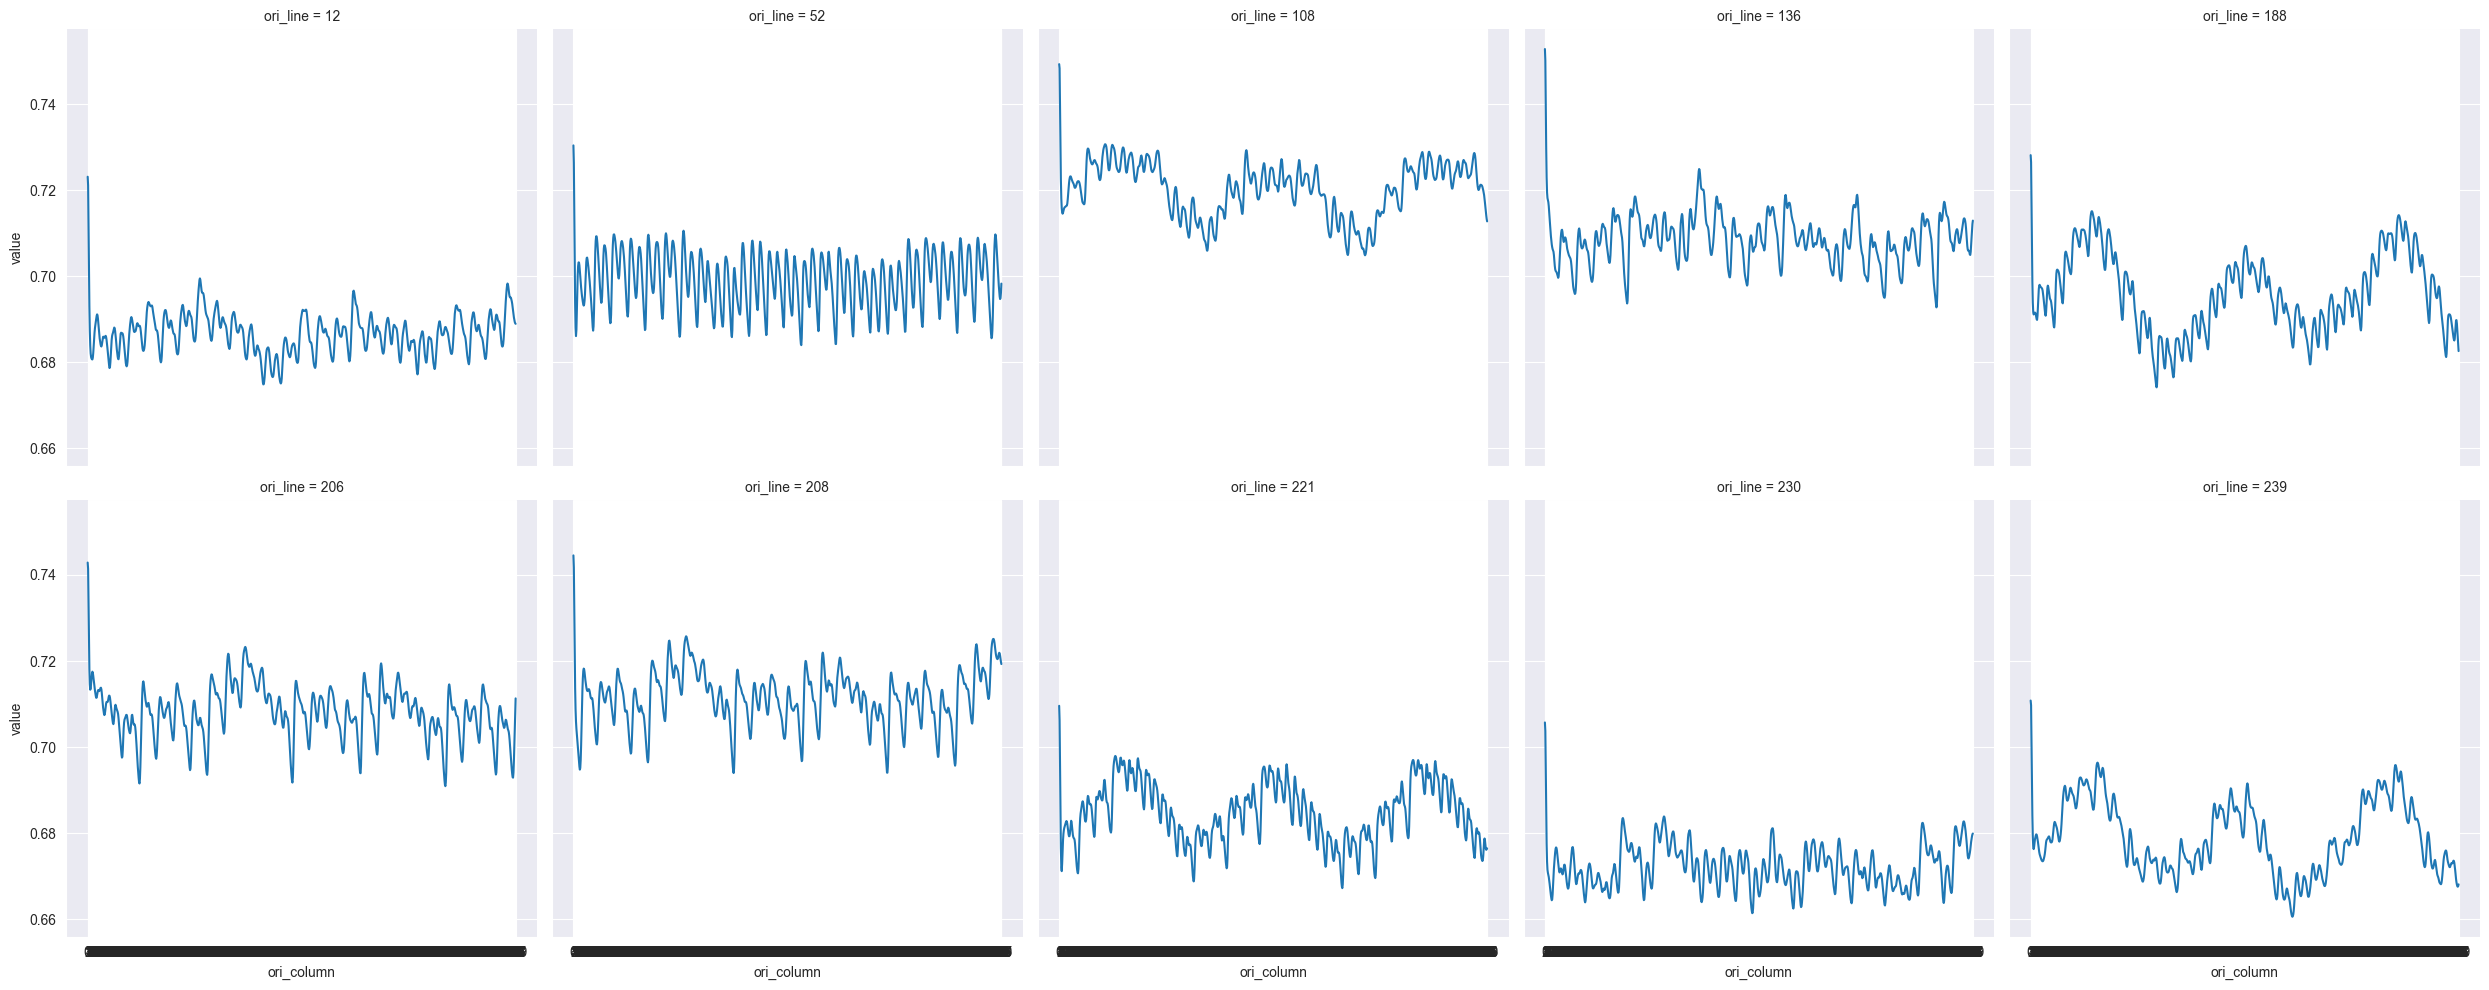

In [22]:
sns.relplot(data=current_samples[0], x='ori_column', y='value', col='ori_line', col_wrap=5, kind='line')

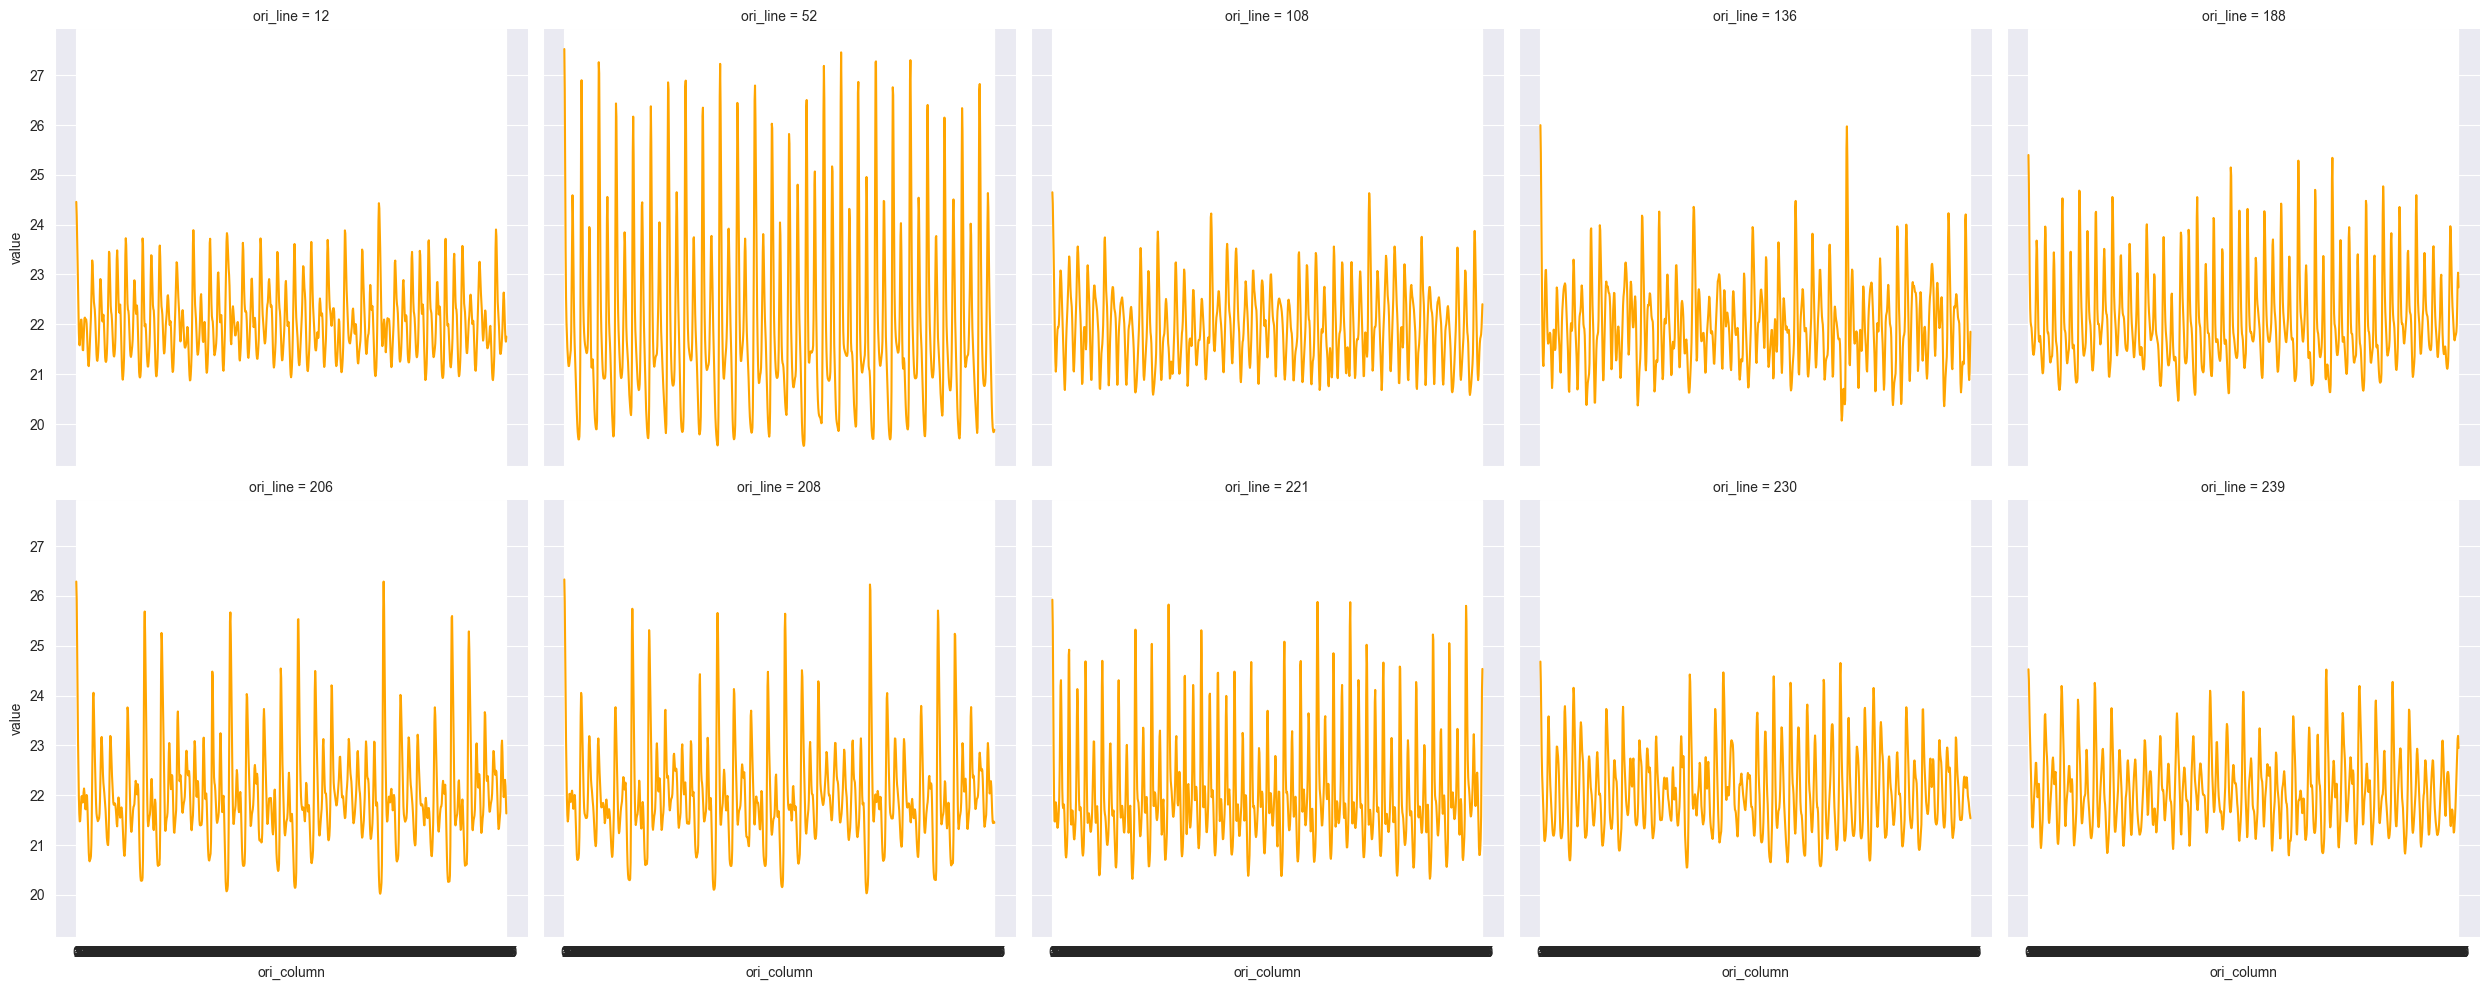

In [23]:
sns.relplot(data=voltage_samples[0], x='ori_column', y='value', col='ori_line', col_wrap=5, kind='line', color='orange')

above we can see ten random samples, for each of them we plot the one thousand measurements made

they all belong to label 0 and there doesn't seem to be any pattern linking them

however, we can clearly see a periodic cycle in some figures

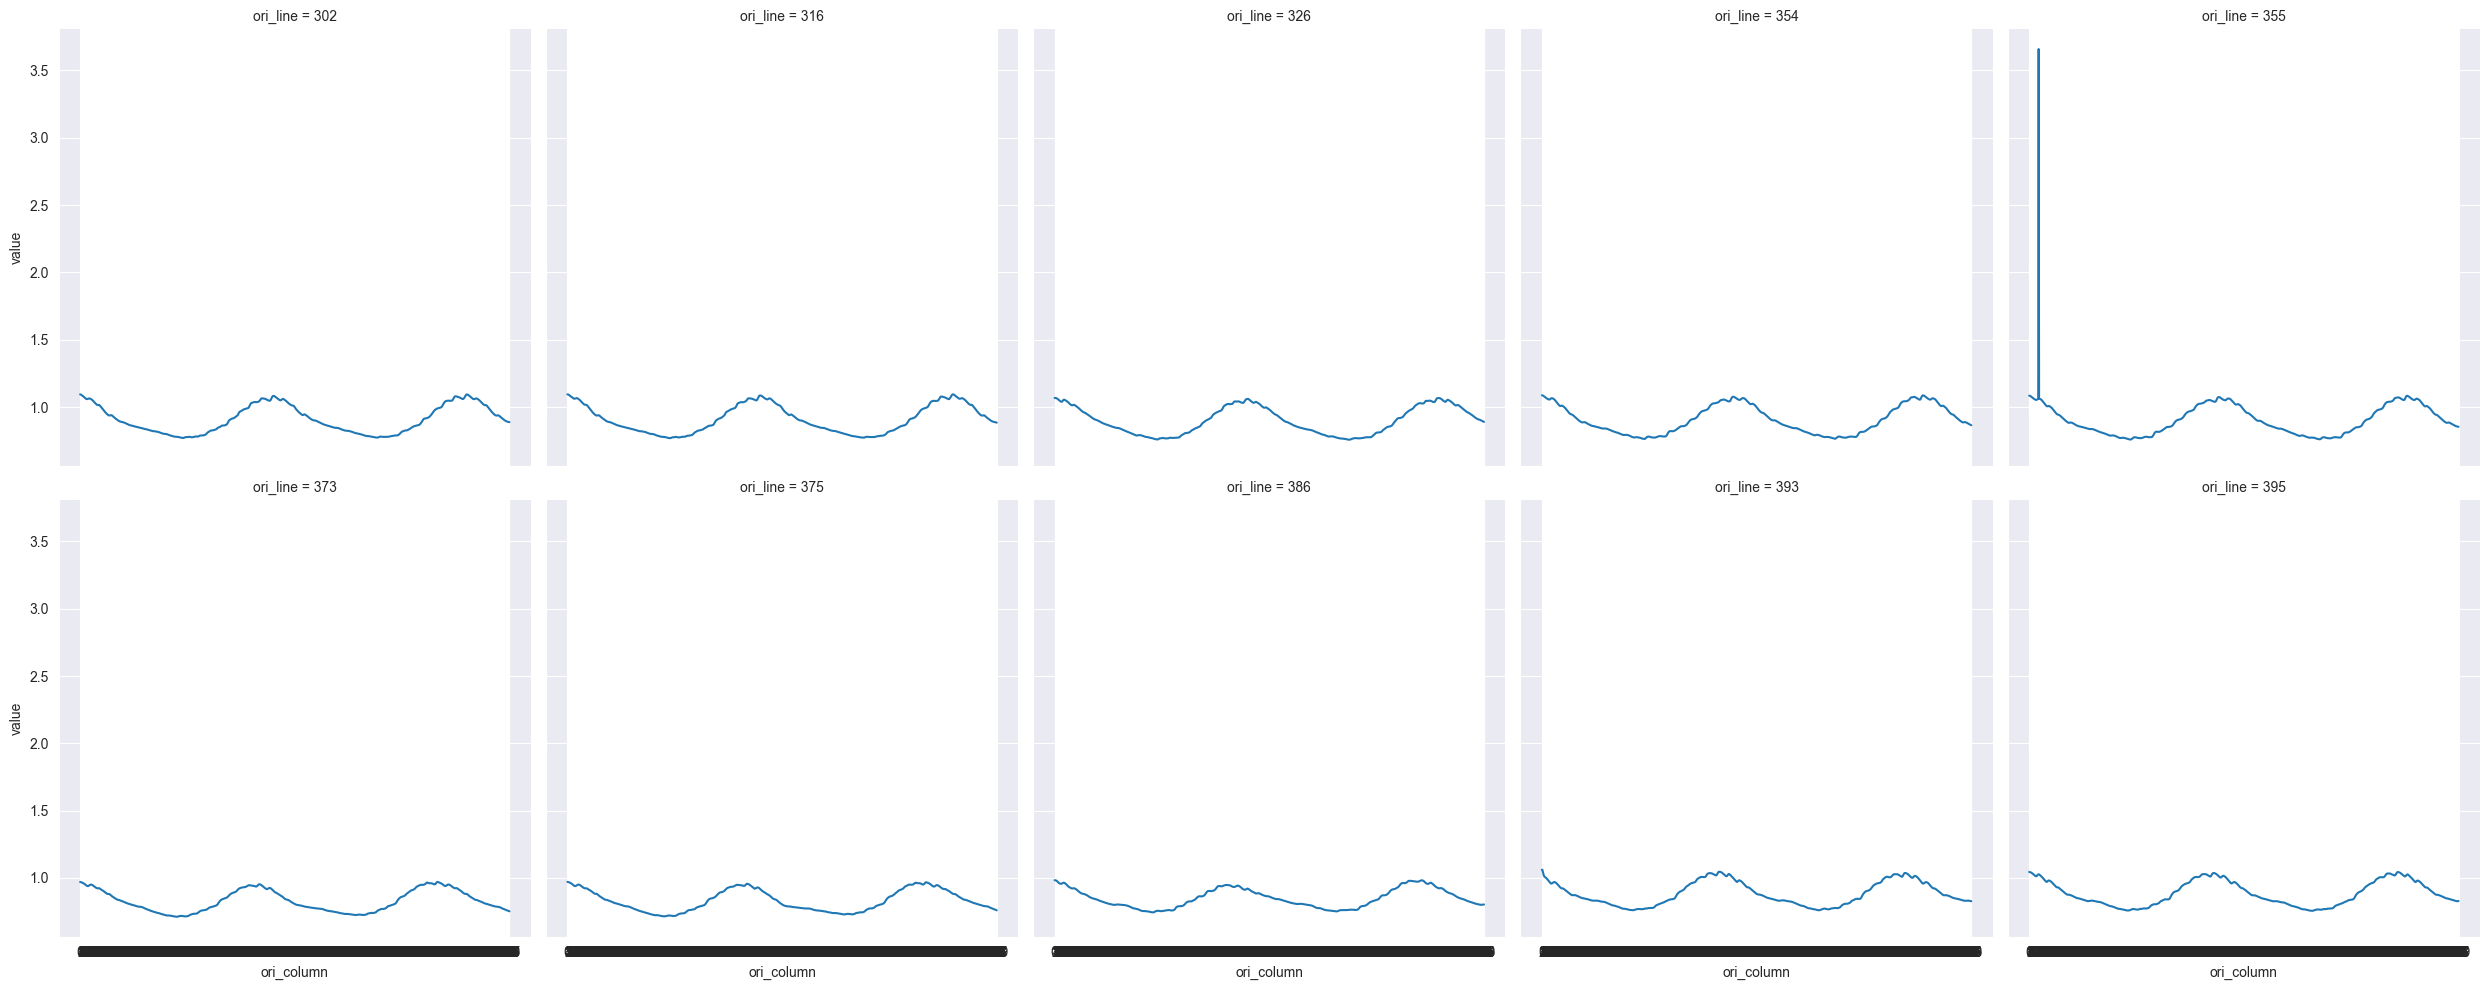

In [24]:
sns.relplot(data=current_samples[1], x='ori_column', y='value', col='ori_line', col_wrap=5, kind='line')

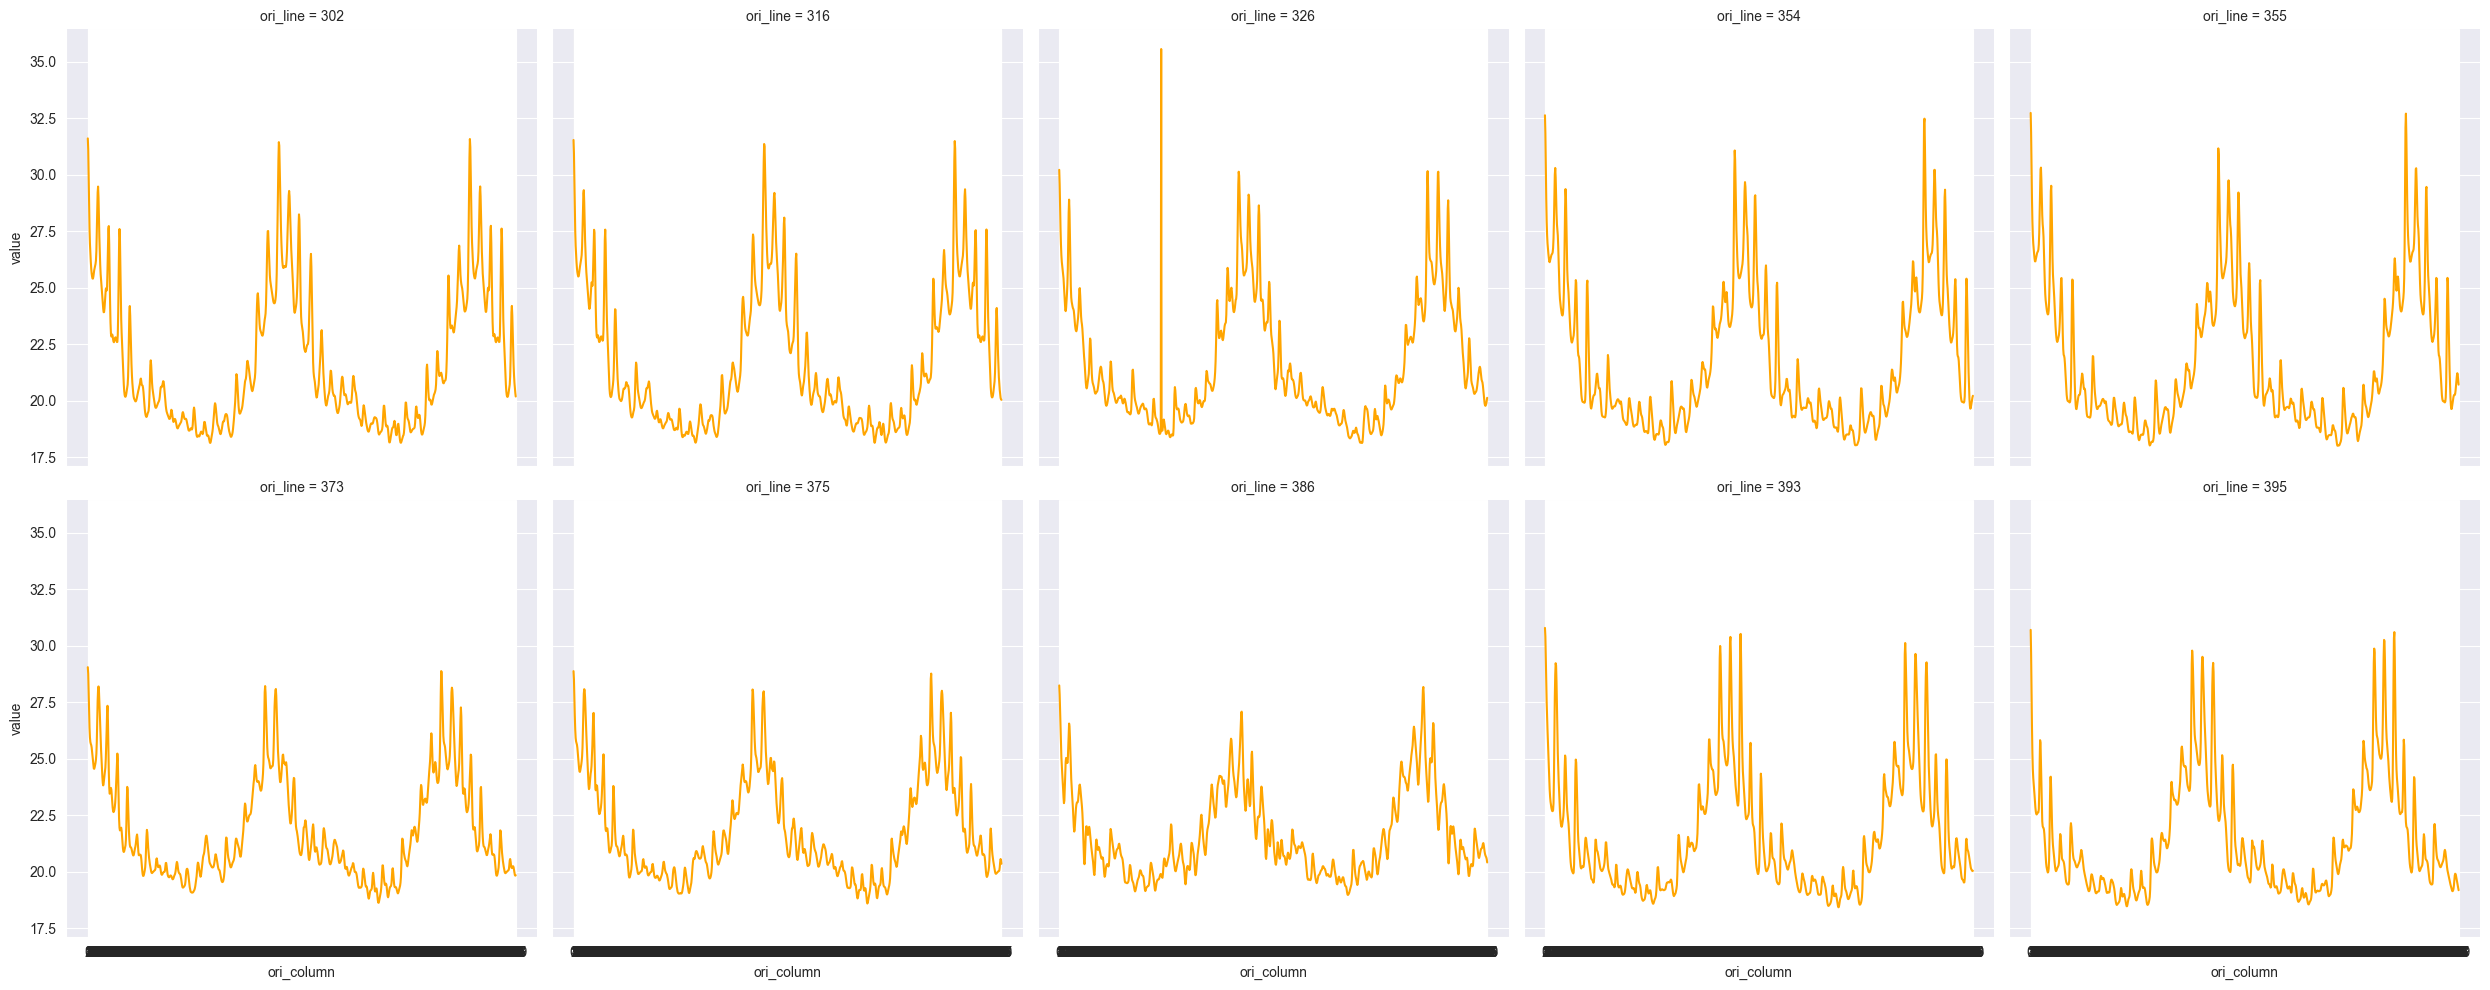

In [25]:
sns.relplot(data=voltage_samples[1], x='ori_column', y='value', col='ori_line', col_wrap=5, kind='line', color='orange')

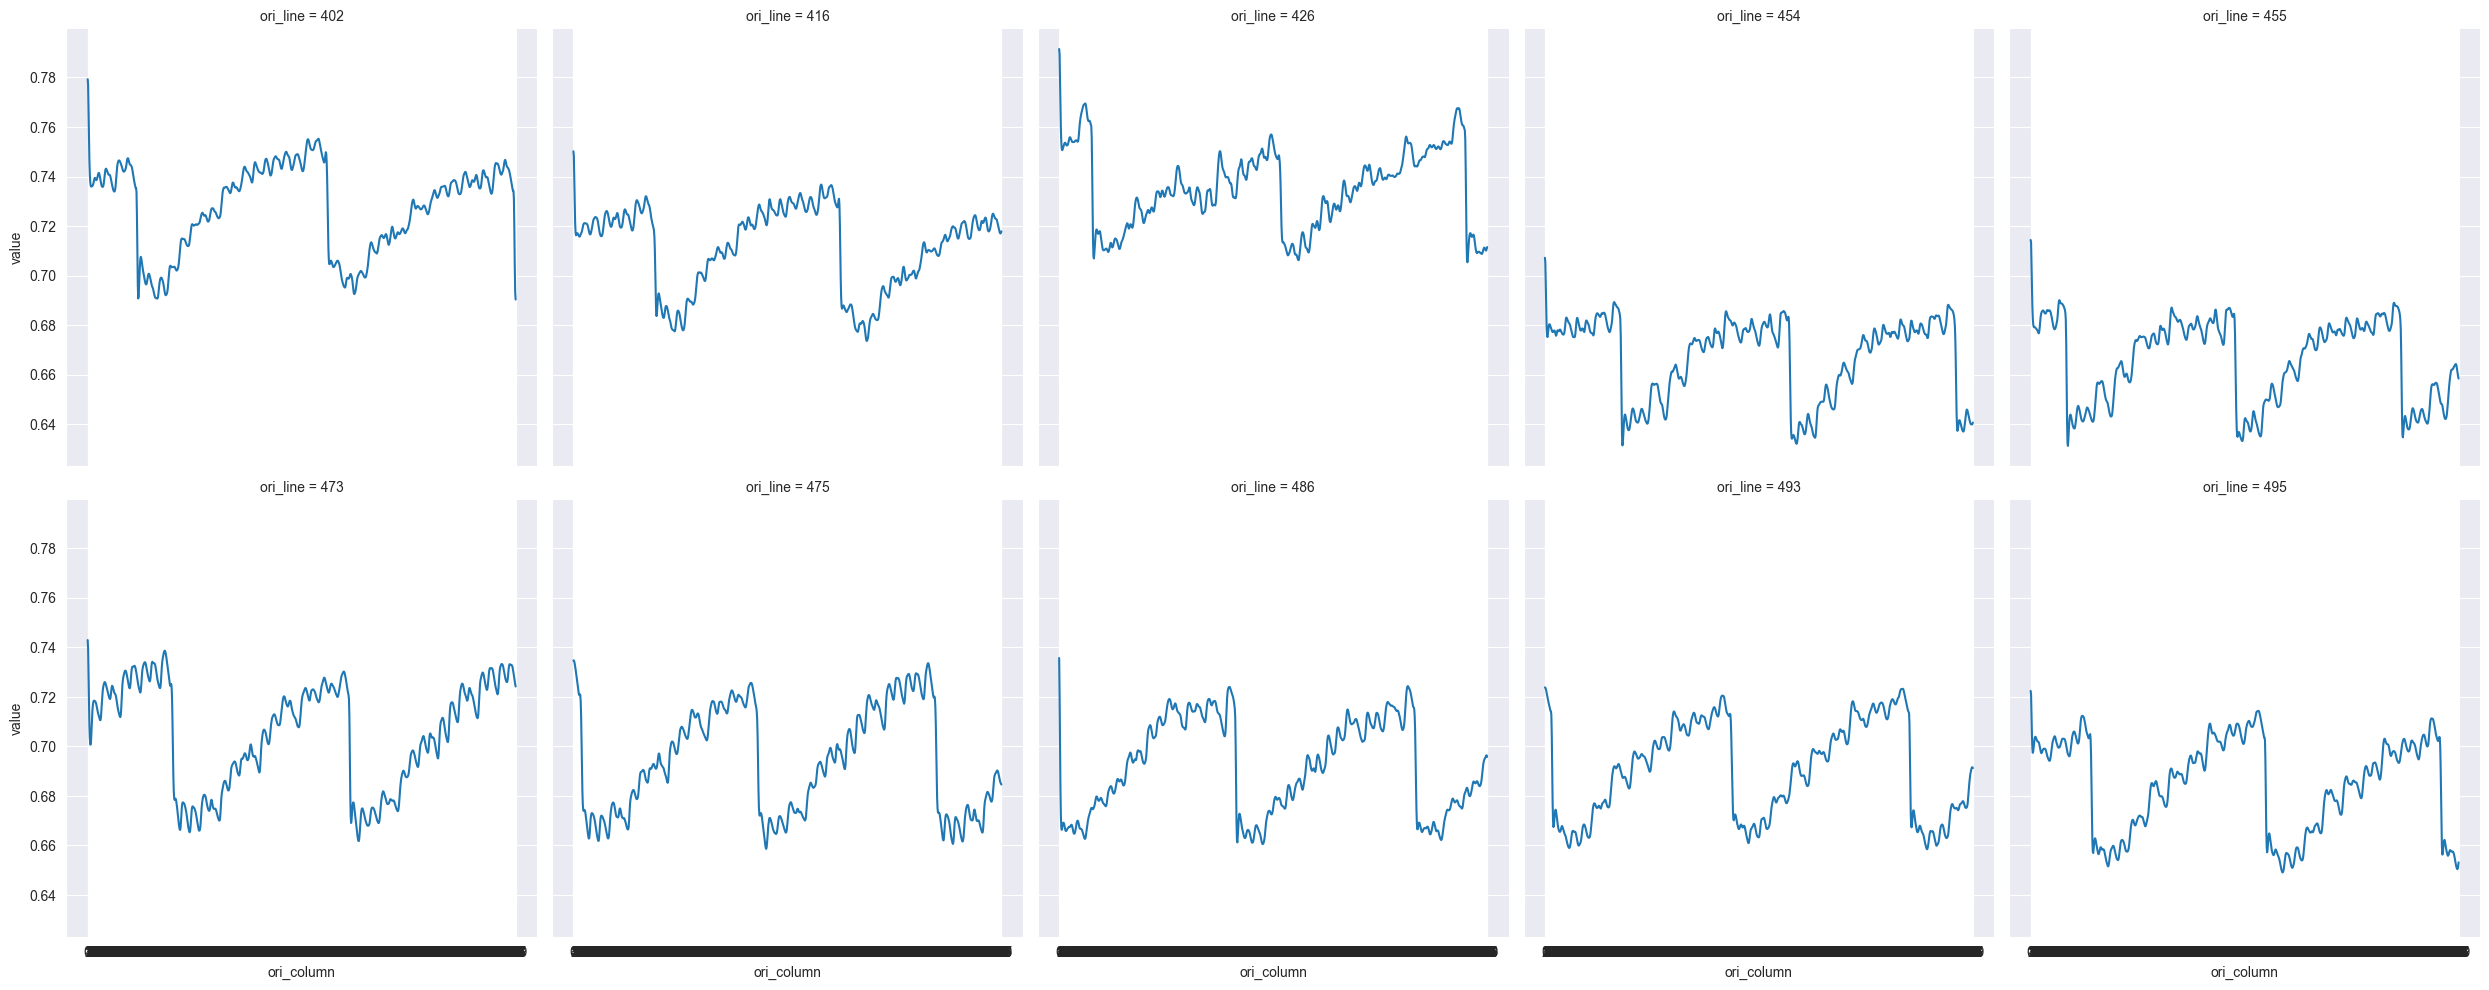

In [26]:
sns.relplot(data=current_samples[2], x='ori_column', y='value', col='ori_line', col_wrap=5, kind='line')

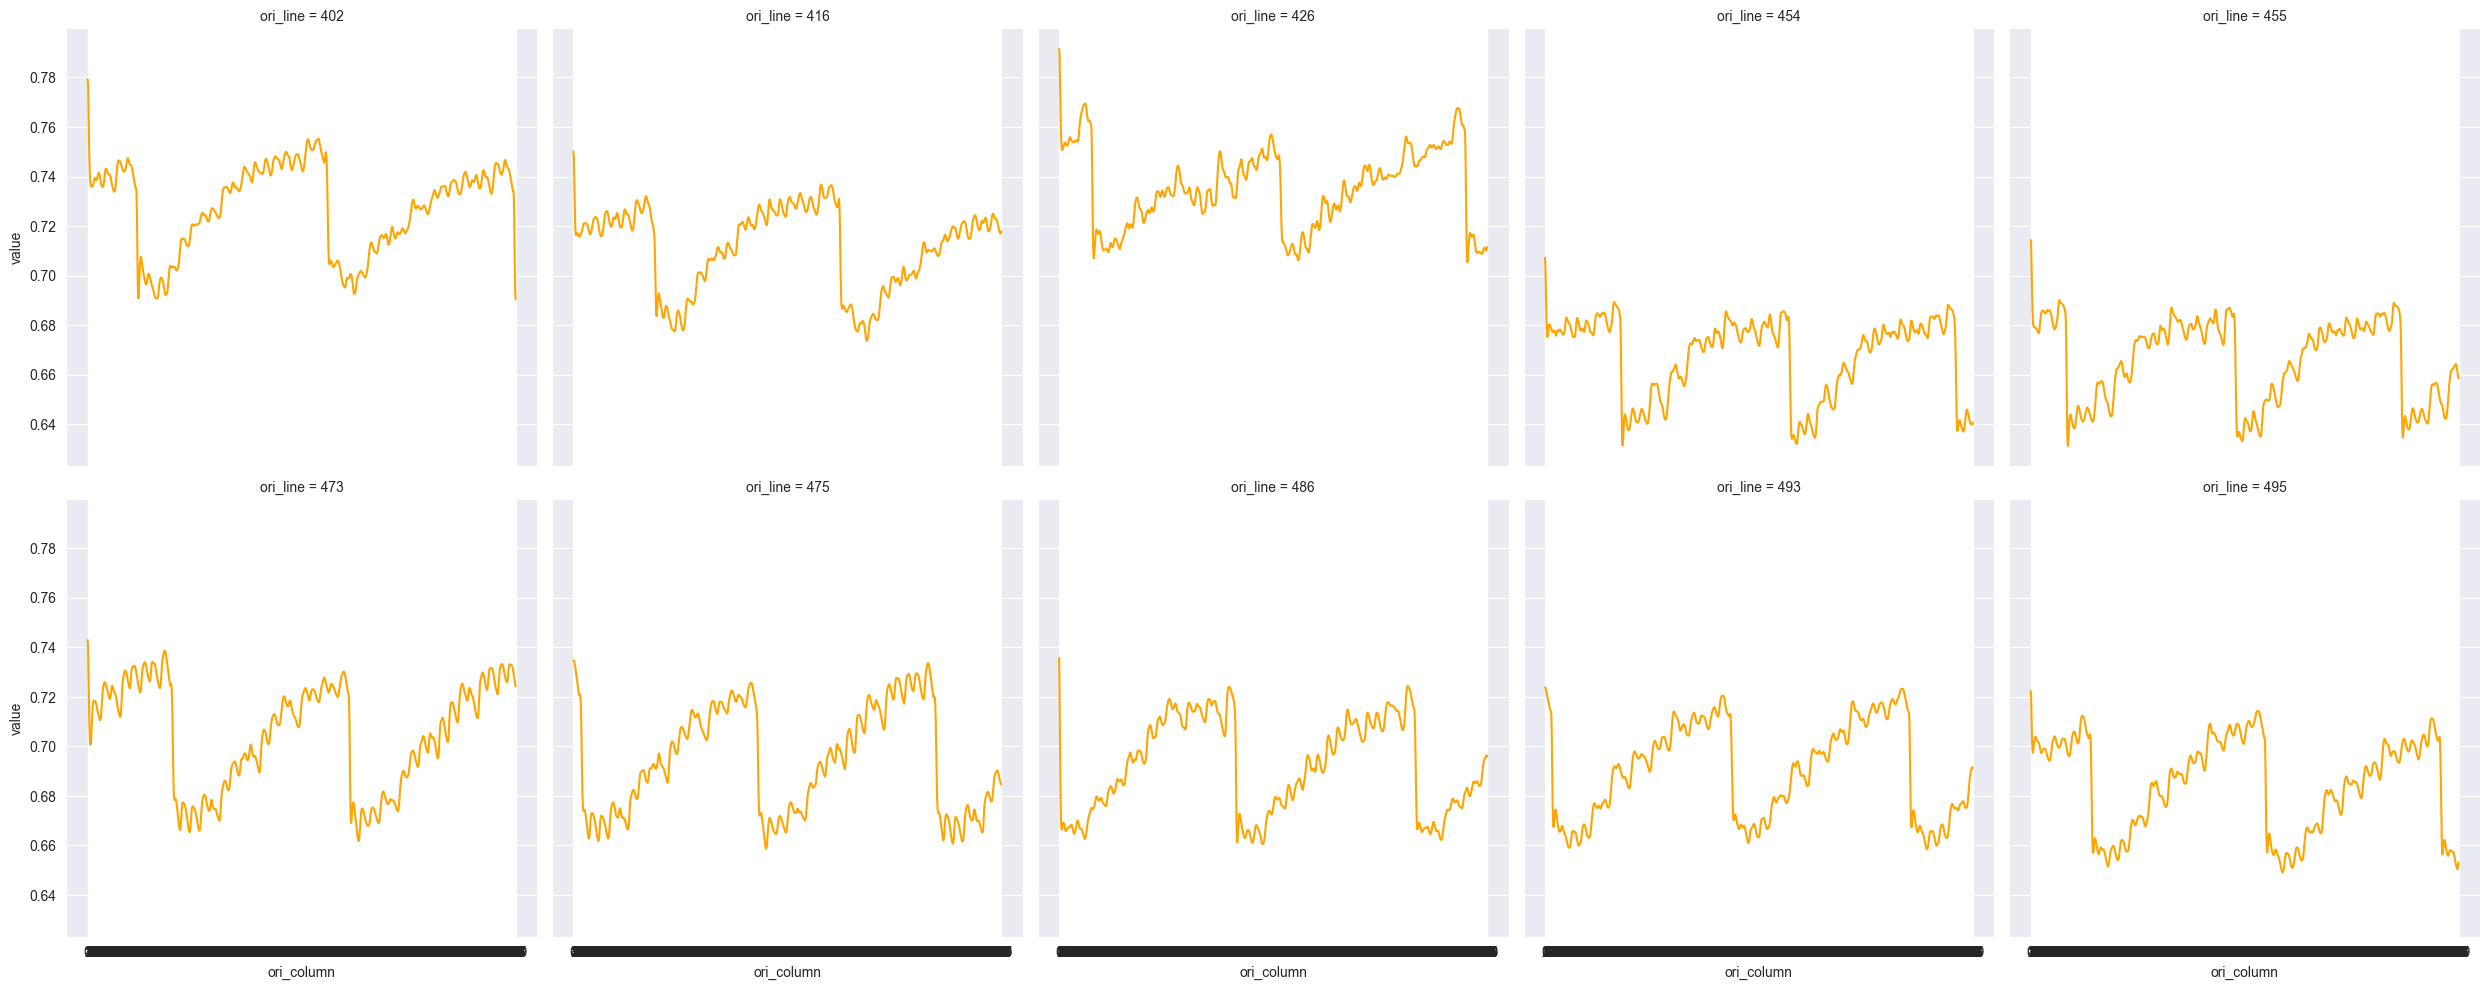

In [27]:
sns.relplot(data=current_samples[2], x='ori_column', y='value', col='ori_line', col_wrap=5, kind='line', color='orange')

we can clearly see this signal is periodic

two thousand lines are too many columns 

so we should reduce the number of measurements per line without losing information

since the measurements are periodic we can cut out the repetition

we will see how transformations are done on a single line

In [22]:
sig = current_samples[0]
sig = sig[sig['ori_line'] == 108]
sig = sig.reset_index()
sig

,index,feature,ori_column,ori_line,value
0,18000,current,0,108,0.749242
1,18001,current,1,108,0.748264
2,18002,current,2,108,0.739357
3,18003,current,3,108,0.729715
4,18004,current,4,108,0.722439
...,...,...,...,...,...
995,18995,current,995,108,0.715982
996,18996,current,996,108,0.715024
997,18997,current,997,108,0.714082
998,18998,current,998,108,0.713266


In [23]:
sig = sig[(np.abs(stats.zscore(sig['value'])) < 3)]
sig.describe()

,index,ori_line,value
count,997.000000,997.0,997.000000
mean,18501.000000,108.0,0.720238
std,287.953411,0.0,0.006096
min,18003.000000,108.0,0.704844
25%,18252.000000,108.0,0.715732
50%,18501.000000,108.0,0.721426
75%,18750.000000,108.0,0.724994
max,18999.000000,108.0,0.730627


first we should smooth out the curve to remove the noise

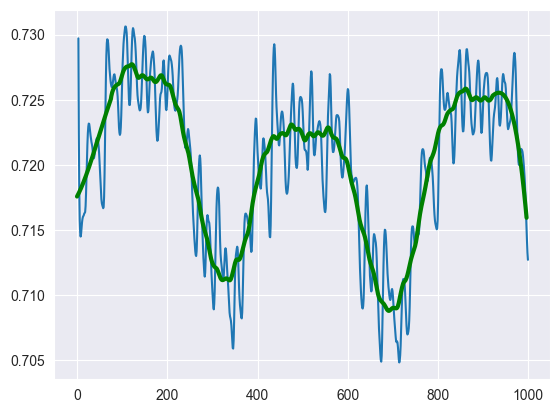

In [26]:
ys = signal.savgol_filter(sig['value'], 151, 3)

plt.plot(sig['value'])
plt.plot(ys, 'g', lw=3)
plt.show()

since the signal repeats three times we will get only the middle part

we can approximate the smoothed curve with way less points, that way we greatly reduce the amount of input data

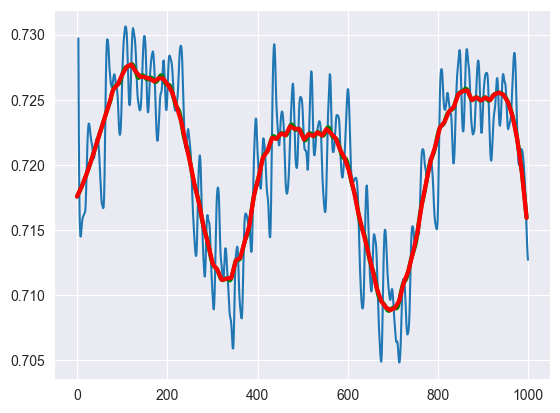

In [41]:
lines = np.linspace(0, len(ys)-1, num=100, dtype=int)
current_data_df = ys[lines]

plt.plot(sig['value'])
plt.plot(ys, 'g', lw=3)
plt.plot(lines, current_data_df, 'r', lw=3)
plt.show()